In [50]:
import polars as pl
import pyodbc
import matplotlib.pyplot as plt
import urllib.parse
import seaborn as sns
from sqlalchemy import text
from sqlalchemy import create_engine
from langdetect import detect, DetectorFactory

# Ensure reproducibility for langdetect
DetectorFactory.seed = 0


In [51]:
# --- Configuration ---
server_name = r"YASSINE\SQLEXPRESS"  # Your SQL Server instance
mdf_file = r"D:\SQLData\AirbnbDataWarehouse.mdf"  # Path to your .mdf
db_name = "AirbnbDataWarehouse"  # Logical database name

# --- Connection string for pyodbc ---
# Using Trusted Connection (Windows authentication)
conn_str = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server_name};"
    f"Trusted_Connection=yes;"
    f"AttachDbFilename={mdf_file};"
    f"DATABASE={db_name};"
)

# --- Attempt connection ---
try:
    cnxn = pyodbc.connect(conn_str)
    print("✅ Successfully connected to the database.")
except pyodbc.Error as ex:
    print("❌ Error connecting to the database:")
    print(ex)
    print("Check that SQL Server is running, the ODBC driver is installed,")
    print("and that the .mdf file is accessible and not already attached.")
    cnxn = None

# --- Create SQLAlchemy engine for pandas or other libraries ---
if cnxn:
    # URL-encode the connection string for SQLAlchemy
    params = urllib.parse.quote_plus(conn_str)
    engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")
    print("✅ SQLAlchemy engine created successfully.")
else:
    engine = None
    print("⚠️ SQLAlchemy engine not created due to connection error.")

# --- Optional: Verify connection by fetching top 5 tables (example) ---
if engine:
    try:
        with engine.connect() as connection:
            result = connection.execute(text("SELECT name FROM sys.tables;"))
            tables = [row[0] for row in result]
            print("Tables in database:", tables)  # print full list
    except Exception as e:
        print("⚠️ Could not fetch tables:", e)

✅ Successfully connected to the database.
✅ SQLAlchemy engine created successfully.
Tables in database: ['dim_listings', 'dim_listing_id_map', 'dim_listings_staging', 'fact_calendar_temp', 'fact_reviews_temp', 'dim_hosts', 'dim_dates', 'fact_calendar', 'fact_reviews']


In [52]:
# --- List Tables in the Database ---
if cnxn:
    try:
        cursor = cnxn.cursor()
        cursor.execute("SELECT TABLE_SCHEMA, TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'")
        tables = cursor.fetchall()
        print("Tables in the database:")
        for table in tables:
            print(f"- {table[0]}.{table[1]}")
    except Exception as e:
        print(f"Error listing tables: {e}")
else:
    print("Cannot list tables: Database connection not established.")

Tables in the database:
- dbo.dim_listings
- dbo.dim_listing_id_map
- dbo.dim_listings_staging
- dbo.fact_calendar_temp
- dbo.fact_reviews_temp
- dbo.dim_hosts
- dbo.dim_dates
- dbo.fact_calendar
- dbo.fact_reviews


## 1. Data Loading

In [53]:
# Load necessary tables into Polars DataFrames
try:
    # Ensure you have connectorx installed: pip install connectorx
    server_encoded = urllib.parse.quote_plus(server_name)
    uri = f"mssql://{server_encoded}/{db_name}?trusted_connection=true"

    df_hosts = pl.read_database_uri(
        query='SELECT * FROM dim_hosts',
        uri=uri,
        partition_on='host_id',
        partition_num=4,
        engine='connectorx'
    )

    df_reviews = pl.read_database_uri(
        query="SELECT review_id, listing_id, date_id, reviewer_id, reviewer_name, comments FROM fact_reviews",
        uri=uri,
        partition_on='review_id',
        partition_num=4,
        schema_overrides={'comments': pl.Utf8},
        engine='connectorx'
    )

    df_listings = pl.read_database_uri(
        query='SELECT * FROM dim_listings',
        uri=uri,
        partition_on='listing_id',
        partition_num=4,
        engine='connectorx'
    )

    print("DataFrames loaded successfully: df_hosts, df_reviews, df_listings")
    
except Exception as e:
    print(f"Error loading data: {e}")

print("--- df_hosts Info ---")
print(df_hosts)
print("--- df_reviews Info ---")
print(df_reviews)
print("--- df_listings Info ---")
print(df_listings)



DataFrames loaded successfully: df_hosts, df_reviews, df_listings
--- df_hosts Info ---
shape: (740_651, 8)
┌───────────┬───────────┬────────────┬────────────┬────────────┬───────────┬───────────┬───────────┐
│ host_id   ┆ host_name ┆ host_city  ┆ host_count ┆ total_list ┆ created_d ┆ corrected ┆ host_coun │
│ ---       ┆ ---       ┆ ---        ┆ ry         ┆ ings       ┆ ate       ┆ _country  ┆ try_corre │
│ i64       ┆ str       ┆ str        ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ cted      │
│           ┆           ┆            ┆ str        ┆ i64        ┆ datetime[ ┆ str       ┆ ---       │
│           ┆           ┆            ┆            ┆            ┆ μs]       ┆           ┆ str       │
╞═══════════╪═══════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╡
│ 180360872 ┆ Fabrício  ┆ Rio de     ┆ Brazil     ┆ 3          ┆ 2025-10-2 ┆ Brazil    ┆ Brazil    │
│           ┆           ┆ Janeiro    ┆            ┆            ┆ 0 15:13:3 ┆        

## 2. Null Value Examination

Columns in df_hosts after dropping host_name:
['host_id', 'host_city', 'host_country', 'total_listings', 'created_date', 'corrected_country', 'host_country_corrected']
--- Null Values in df_hosts ---
No null values found in df_hosts.
--- Null Values in df_reviews ---
shape: (1, 3)
┌───────────────┬────────────┬─────────────────┐
│ Column        ┆ Null Count ┆ Null Percentage │
│ ---           ┆ ---        ┆ ---             │
│ str           ┆ i64        ┆ f64             │
╞═══════════════╪════════════╪═════════════════╡
│ reviewer_name ┆ 17         ┆ 0.000267        │
└───────────────┴────────────┴─────────────────┘


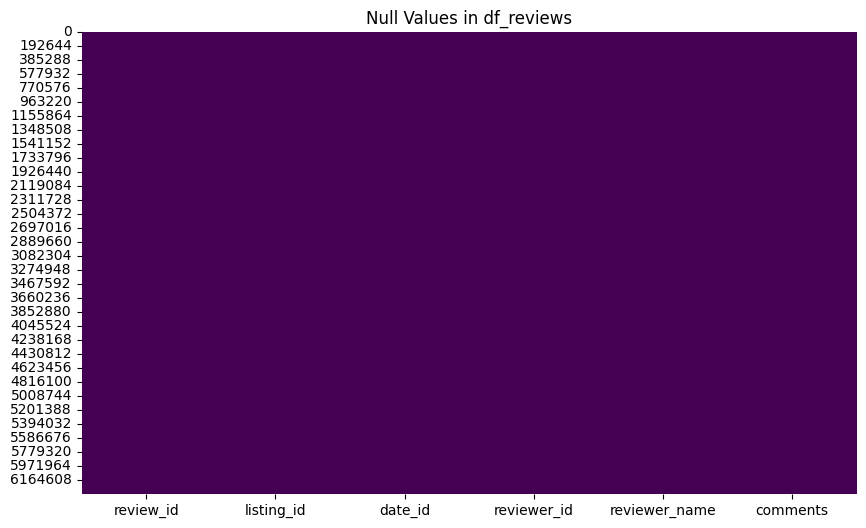

--- Null Values in df_listings ---
shape: (5, 3)
┌────────────────────────┬────────────┬─────────────────┐
│ Column                 ┆ Null Count ┆ Null Percentage │
│ ---                    ┆ ---        ┆ ---             │
│ str                    ┆ i64        ┆ f64             │
╞════════════════════════╪════════════╪═════════════════╡
│ review_scores_rating   ┆ 302617     ┆ 20.255082       │
│ price                  ┆ 251406     ┆ 16.827373       │
│ host_name              ┆ 19092      ┆ 1.277886        │
│ property_neighbourhood ┆ 1078       ┆ 0.072154        │
│ longitude              ┆ 21         ┆ 0.001406        │
└────────────────────────┴────────────┴─────────────────┘


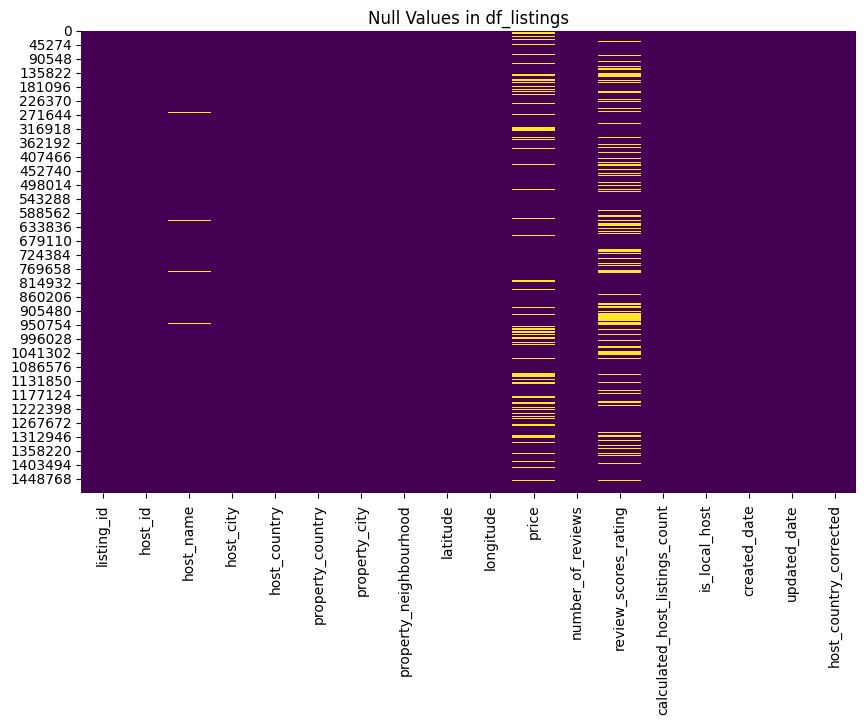

In [54]:
def check_null_values(df, df_name):
    print(f"--- Null Values in {df_name} ---")
    
    null_info_list = []
    for col in df.columns:
        count = df[col].null_count()
        if count > 0:
            percentage = (count / len(df)) * 100
            null_info_list.append({'Column': col, 'Null Count': count, 'Null Percentage': percentage})
            
    if not null_info_list:
        print(f"No null values found in {df_name}.")
        return
        
    null_info = pl.DataFrame(null_info_list).sort('Null Percentage', descending=True)
    print(null_info)

    plt.figure(figsize=(10, 6))
    # Convert to pandas for seaborn heatmap
    sns.heatmap(df.select([pl.col(c).is_null() for c in df.columns]).to_pandas(), cbar=False, cmap='viridis')
    plt.title(f'Null Values in {df_name}')
    plt.show()

# Drop the host_name column as it has too many null values
df_hosts = df_hosts.drop('host_name')

# Verify that the column has been dropped
print("Columns in df_hosts after dropping host_name:")
print(df_hosts.columns)

check_null_values(df_hosts, 'df_hosts')
check_null_values(df_reviews, 'df_reviews')
check_null_values(df_listings, 'df_listings')


## 3. "Unknown" Value Examination

--- 'Unknown' Values in df_hosts ---
shape: (4, 2)
┌────────────────────────┬────────┐
│ Column                 ┆ Count  │
│ ---                    ┆ ---    │
│ str                    ┆ i64    │
╞════════════════════════╪════════╡
│ host_city              ┆ 213874 │
│ host_country           ┆ 198302 │
│ corrected_country      ┆ 198302 │
│ host_country_corrected ┆ 198302 │
└────────────────────────┴────────┘


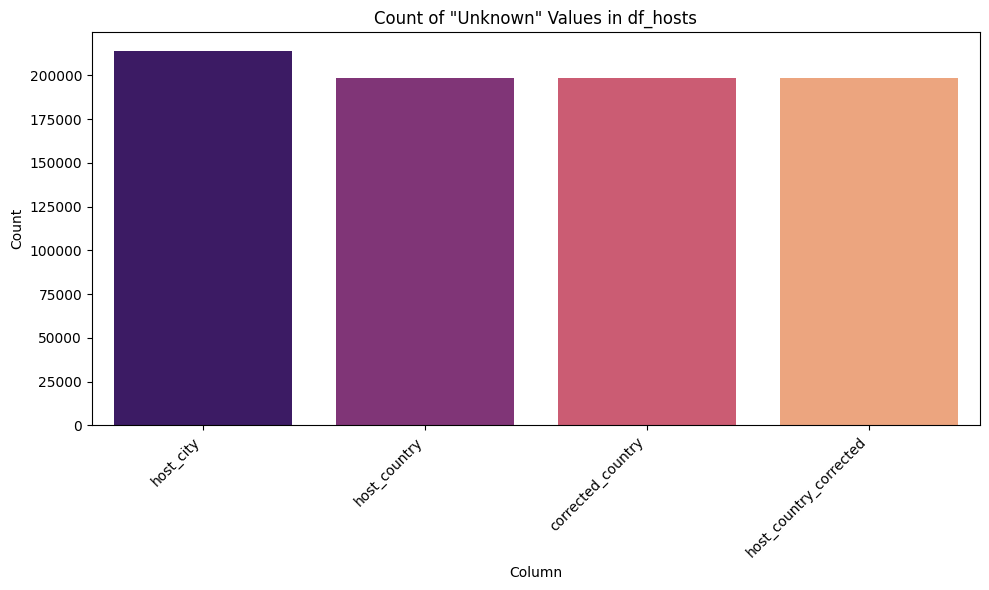

--- 'Unknown' Values in df_reviews ---
shape: (1, 2)
┌───────────────┬───────┐
│ Column        ┆ Count │
│ ---           ┆ ---   │
│ str           ┆ i64   │
╞═══════════════╪═══════╡
│ reviewer_name ┆ 4     │
└───────────────┴───────┘


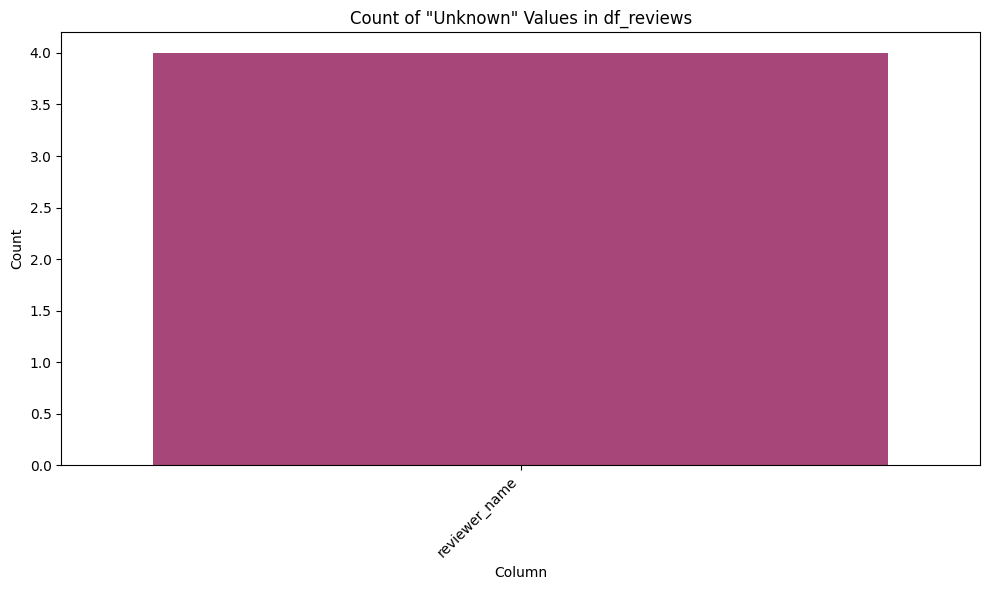

--- 'Unknown' Values in df_listings ---
shape: (5, 2)
┌────────────────────────┬────────┐
│ Column                 ┆ Count  │
│ ---                    ┆ ---    │
│ str                    ┆ i64    │
╞════════════════════════╪════════╡
│ host_city              ┆ 439348 │
│ host_country           ┆ 399009 │
│ host_country_corrected ┆ 399009 │
│ property_neighbourhood ┆ 93322  │
│ host_name              ┆ 2      │
└────────────────────────┴────────┘


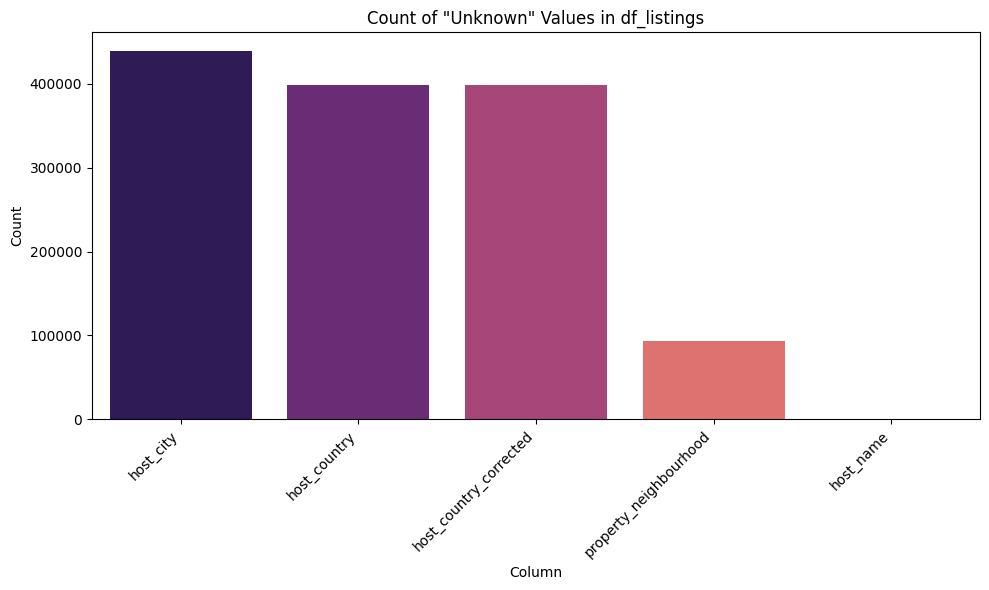

In [55]:
def check_unknown_values(df, df_name, unknown_values=['unknown', 'n/a', '-', 'none', '', 'null', 'not available']):
    print(f"--- 'Unknown' Values in {df_name} ---")
    
    unknown_counts = {}
    # In Polars, we select columns by dtype.
    for col_name in df.select(pl.col(pl.Utf8)).columns:
        # Filter rows where the lowercased value is in the unknown_values list
        count = df.filter(pl.col(col_name).str.to_lowercase().is_in(unknown_values)).height
        if count > 0:
            unknown_counts[col_name] = count
            
    if unknown_counts:
        # Convert the dictionary to a Polars DataFrame for sorting and printing
        unknown_info = pl.DataFrame({
            'Column': list(unknown_counts.keys()),
            'Count': list(unknown_counts.values())
        }).sort('Count', descending=True)
        
        print(unknown_info)
        
        # For plotting, convert the Polars DataFrame to a Pandas DataFrame
        unknown_info_pd = unknown_info.to_pandas()
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Column', y='Count', data=unknown_info_pd, hue='Column', palette='magma', legend=False)
        plt.title(f'Count of "Unknown" Values in {df_name}')
        plt.ylabel('Count')
        plt.xlabel('Column')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No common 'unknown' values found in string columns of {df_name}.")

check_unknown_values(df_hosts, 'df_hosts')
check_unknown_values(df_reviews, 'df_reviews')
check_unknown_values(df_listings, 'df_listings')


## Dropping host_country column 

In [57]:
# Drop the original host_country column and rename the corrected one
df_hosts = df_hosts.drop('host_country')
df_hosts = df_hosts.rename({'host_country_corrected': 'host_country'})

# Verify the changes
print("Columns in df_hosts after cleanup:")
print(df_hosts.columns)

Columns in df_hosts after cleanup:
['host_id', 'host_city', 'total_listings', 'created_date', 'corrected_country', 'host_country']
